In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Set the following parameters to determine which stations have "good" availability

syear = 2008  # Good stations will only be identified based on info between syear and eyear
eyear = 2008
'''Solar Maxima: 2002, 2014
   Solar Minima: 1997, 2009, 2020'''
low_lat = 35. # The minimum geographic latitude of stations to be considered
high_lat = 70. # The maximum geographic latitude of stations to be considered
w_lon = 210. # The minimum geographic longitude of stations to be considered
e_lon = 300. # The maximum geographic latitude of stations to be considered
avg_avail_min = 40 # Stations whose average percent available data over the years of consideration are less than this are eliminated
year_avail_min = 40  # Stations that don't have at least this much available data every year are eliminated
all_stations_path = "supermag_table.csv" # The path to your raw SuperMAG data table

In [3]:
# Run the previous cell before running this one!

all_stations = pd.read_csv(all_stations_path)

year_range = np.arange(syear, eyear+1)

if w_lon > e_lon:
    w_lon -= 360
    
# Select only the relevant years
all_cols = all_stations.columns.values
to_drop = []
for col_num in range(6, len(all_stations.iloc[1])):
    if int(all_cols[col_num]) not in year_range:
        to_drop.append(all_stations.columns[col_num])
all_stations = all_stations.drop(to_drop, axis=1)

# Select only the stations in the relevant region
outside_stations = []
for station in range(len(all_stations)):
    row = all_stations.iloc[station]
    if row["GLAT"] < low_lat or row["GLAT"] > high_lat or row["GLON"] < w_lon or row["GLON"] > e_lon:
        outside_stations.append(station)
geo_stations = all_stations.drop(outside_stations)

# Select only the stations with average availability >= avail_min
good_stations = pd.DataFrame([])
for row_num in range(len(geo_stations)):
    new_row = geo_stations.iloc[row_num][:6]
    pcts = []
    for col_num in range(6, len(geo_stations.iloc[1])):
        pct_str = geo_stations.iloc[row_num][col_num]
        pct = float(pct_str[:-1])
        pcts.append(pct)
    if np.sum(pcts) > avg_avail_min*(len(geo_stations.iloc[1])-6) and np.size(np.where(np.array(pcts)<year_avail_min)) == 0:
        new_row = pd.concat([new_row, pd.DataFrame(pcts)])
        good_stations = pd.concat([good_stations, new_row], axis=1, ignore_index=True)


print(good_stations.loc["IAGA"].values)
print(f"{len(good_stations.loc['IAGA'].values)} stations")

['AMU' 'YKC' 'CBB' 'BLC' 'MEA' 'SIT' 'BOU' 'VIC' 'NEW' 'OTT' 'FRD' 'GIM'
 'TAL' 'DAW' 'FCC' 'FMC' 'FSP' 'SMI' 'ISL' 'PIN' 'RAL' 'RAN' 'INK' 'FYU'
 'EAG' 'CMO' 'GAK' 'PKR' 'IQA' 'CDC' 'RPB' 'NAN' 'FSJ' 'LET' 'RED' 'HLM'
 'M01' 'M04' 'M05' 'M06' 'T16' 'T18' 'T19' 'T20' 'T21' 'T22' 'T23' 'T24'
 'T25' 'T28' 'T29' 'T31' 'T32' 'T33' 'T36' 'T37' 'T38' 'T43' 'T51' 'WAD'
 'LCL']
61 stations


210.0


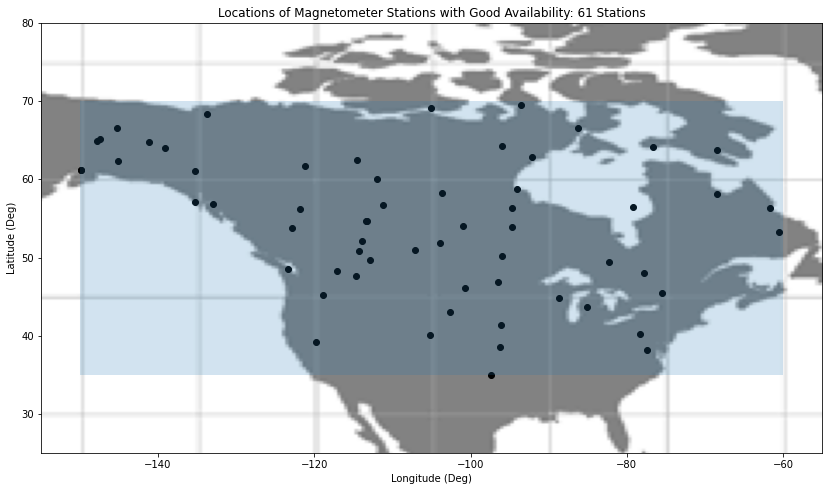

In [4]:
# Run the previous cells before running this one!

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14,14))
img=mpimg.imread('world_map.jpg')
ax.imshow(img, extent=[-180,180,-90,90])

print(w_lon)
if w_lon >= 180:
    w_lon -= 360
    e_lon -= 360
    
lats = good_stations.loc["GLAT"].values
lons = good_stations.loc["GLON"].values
for i in range(len(lons)):
    if lons[i] >= 180:
        lons[i] -= 360

        
ax.scatter(lons, lats, c="Black")
ax.add_patch(Rectangle((w_lon, low_lat), e_lon-w_lon, high_lat-low_lat, alpha=0.2))
ax.set_xlim(w_lon-5,e_lon+5)
ax.set_ylim(low_lat-10, high_lat+10)
plt.xlabel("Longitude (Deg)")
plt.ylabel("Latitude (Deg)")
plt.title(f"Locations of Magnetometer Stations with Good Availability: {len(lats)} Stations")
plt.savefig("good_locs.png")